In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import operator
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
PATH = '..\\yelp_labelled.txt'
names=['sentence', 'positive']
df = pd.read_table(PATH, header=None, names=names)
df.head()

,sentence,positive
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
sns.set_style('white')

keywords = ['great', 'good', 'back', 'delicious', 'tasty', 'nice', 'service', 'loved',
           'enjoyed', 'friendly', 'amazing', 'like', 'excellent', 'very']
for key in keywords:
    df[str(key)] = df.sentence.str.contains(
    ' ' + str(key) + ' ',
    case=False
    )
df['positive'] = (df['positive'] == 1)
df.head()

,sentence,positive,great,good,back,delicious,tasty,nice,service,loved,enjoyed,friendly,amazing,like,excellent,very
0,Wow... Loved this place.,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,Crust is not good.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty.,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,The selection on the menu was great and so wer...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


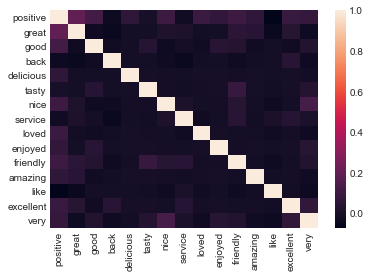

In [4]:
sns.heatmap(df.corr())
plt.show()

In [5]:
data = df[keywords]
target = df['positive']

from sklearn.naive_bayes import BernoulliNB

# Instantiate our model as bnb
bnb = BernoulliNB()

# Use the Fit method
bnb.fit(data, target)

# Make predictions, and store the result in y_pred
y_pred = bnb.predict(data)

# Display the results
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 379


Okay so that is all pretty much just copied and pasted from the curriculum.
It barely go 60% correct. Let's see which words appear most often in good reviews

In [6]:
# filtered_words = [word for word in word_list if word not in stopwords.words('english')]
buzzwords = {}
ps = PorterStemmer()
for each in df[df['positive']]['sentence']:
    each = each.replace('.', '').replace('!', '').split(' ')
    for word in each:
        new_word = ps.stem(word)
        if new_word in buzzwords:
            buzzwords[new_word] = buzzwords[new_word] + 1
        else:
            buzzwords[new_word] = 1

sorted_list = sorted(buzzwords.items(), key=operator.itemgetter(1))

In [7]:
# I'm shortening this for viewing purposes in github
list(reversed(sorted_list))[0:20]

[('the', 309),
 ('and', 222),
 ('wa', 138),
 ('I', 113),
 ('a', 107),
 ('is', 104),
 ('to', 85),
 ('thi', 77),
 ('good', 67),
 ('great', 65),
 ('in', 56),
 ('place', 56),
 ('food', 52),
 ('of', 52),
 ('veri', 46),
 ('it', 44),
 ('for', 43),
 ('with', 41),
 ('servic', 40),
 ('had', 37)]

### Evaluating the model
I have already talked to Katherine about skimming through this part so I will just give an overview of evaluation metrics and how I would change the model.

In [8]:
from sklearn import metrics

con_mat = metrics.confusion_matrix(target, y_pred)
accuracy = (con_mat[0,0] + con_mat[1,1]) / np.sum(con_mat)

# I coooouuuuld do a similar calculation using index slicing for specificity and sensitivity.
# Or I could have sklearn do it for me :)
specificity = metrics.precision_score(target, y_pred)
sensitivity = metrics.recall_score(target, y_pred)
f1_score = metrics.f1_score(target, y_pred)

print('Confusion Matrix: \n', con_mat, '\n')
print('Accuracy: \n', accuracy, '\n')
print('Specificity: \n', specificity, '\n')
print('Sensitivity: \n', sensitivity, '\n')
print('F1 Score: \n', f1_score, '\n')

Confusion Matrix: 
 [[462  38]
 [341 159]] 

Accuracy: 
 0.621 

Specificity: 
 0.807106598985 

Sensitivity: 
 0.318 

F1 Score: 
 0.456241032999 



The accuracy of our model is better than randomly guessing, but not by much! I would need to spend a lot more time feature engineering to bring this up, and the two methods below should also help the accuracy. 

As you can see, the sensitivity score is relatively low. This means that we are getting a lot of False Negatives from our model. Specifically, our model is classifying a lot of positive reviews as negative. This is most likely due to a lack of features. Since our list of features is all our model is given to find positive reviews, it makes sense that if a positive review does not have any of the buzzwords in it, then the review will be deemed a bad review. I don't want to spend much more time adding new features to our buzzwords, so I won't.

The Specificity number is not too bad, but if I were to try and improve this number, I would look at the reviews that fall into this category. These reviews are negative reviews but they have enough buzzwords in them to get classified as a positive review. If I looked at the sentences for these examples, I might see that all of these examples contain the same buzzword. I would compare the f1 score before and after taking this buzzword out to ensure we don't generate too many more false negatives as a result. If the tradeoff is too high, I might just have to leave it in my model, or perhaps make a very specific bi-gram if I can find a pattern.